Perform preprocessing on multiple images


In [1]:
import nrrd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import cv2
import scipy

import SimpleITK as sitk 
import os 

import ipynb 

# import ipynb.fs.full.imageSubtraction 
from imageSubtractionFunctions import *
# %run imageSubtraction.ipynb


In [2]:
def convertNdArrayToCV2Image(image, resolution = (64,64)):
    """ Converts a numpy array to a cv2 image """
    image = np.array(image, dtype=np.uint8)
    image = cv2.resize(image, resolution)
    return image

In [3]:
def preprocess(whole, wholeHeader, segment, segmentHeader):
    #Grab information about the spacing and the pixels of the whole image and the segment
    whole_spacing = wholeHeader['space directions'] 
    whole_space = wholeHeader['space']
    whole_space_origin = wholeHeader['space origin']

    segment_spacing = segmentHeader['space directions'] 
    segment_space = segmentHeader['space']
    segment_space_origin = segmentHeader['space origin']


    use_hu = wholeHeader['0028|1054'] == 'HU' # States if the image is in HU units
    hu_intercept = wholeHeader['0028|1052'] 
    hu_rescale = wholeHeader['0028|1053']

    # Grab information about the spacing of the pixels of the segmented image 

    segment_spacing = segmentHeader['space directions'] 
    # Windowing parameters for the abdomen
    ABDOMEN_UPPER_BOUND = 215
    ABDOMEN_LOWER_BOUND = -135
    window_center = (ABDOMEN_UPPER_BOUND+ABDOMEN_LOWER_BOUND) / 2
    window_width = (ABDOMEN_UPPER_BOUND-ABDOMEN_LOWER_BOUND) / 2

    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)
    augmented_whole, whole_spacing = resample_spacing(augmented_whole, whole_spacing)

    # Resample the segment image to the same spacing as the whole image
    augmented_segment = segment
    augmented_segment, segment_spacing = resample_spacing(augmented_segment, segment_spacing)

    print('Whole and Image are aligned:', check_alignment([whole_spacing, whole_space, whole_space_origin], [segment_spacing, segment_space, segment_space_origin]))

    # plt.imshow(augmented_whole[:, :, 53], cmap="gray")

    # Get the slice indices where the segment is present in 
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[-1]):
        if len(np.unique(augmented_segment[:,:,index])) > 1:
            segmentedSlices.append(index)


    overlay_segment = augmented_whole * augmented_segment
    # print(overlay_segment.shape)

    # print("Dimension of the CT scan is:", image.shape)
    # plt.imshow(overlay_segment[:, :, 133], cmap="gray")

    
    
            
    croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices)
    # croppedSegment = window_image_to_adbomen(croppedSegment, window_center, window_width)
    croppedSegment[croppedSegment<0.1]=0 # Window the image so that the background is completely black for all slices

    croppedSegment = convertNdArrayToCV2Image(croppedSegment)

    
    print(f'CroppedSegment shape: {croppedSegment.shape}')
    # Display the segmented image slices 

    columnLen = 10
    rowLen = croppedSegment.shape[-1] // columnLen + 1
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    
    rowIdx = 0
    for idx in range(croppedSegment.shape[-1]):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(croppedSegment[:,:,idx], cmap="gray")
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    return croppedSegment


CASE630
Whole and Image are aligned: True
hi
148 250 121 201
CroppedSegment shape: (64, 64, 31)


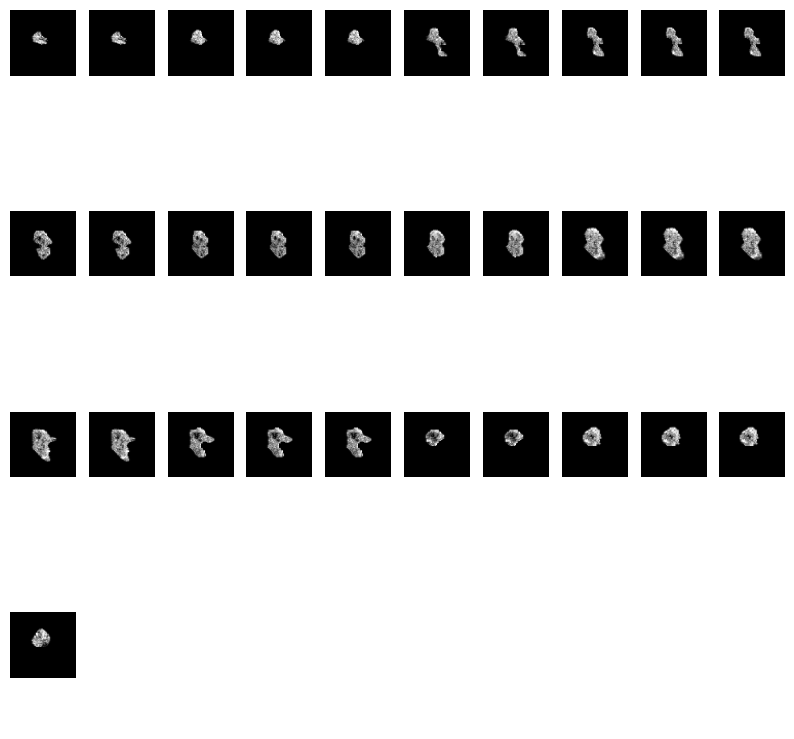

CASE632
Whole and Image are aligned: True
hi
186 280 172 266
CroppedSegment shape: (64, 64, 32)


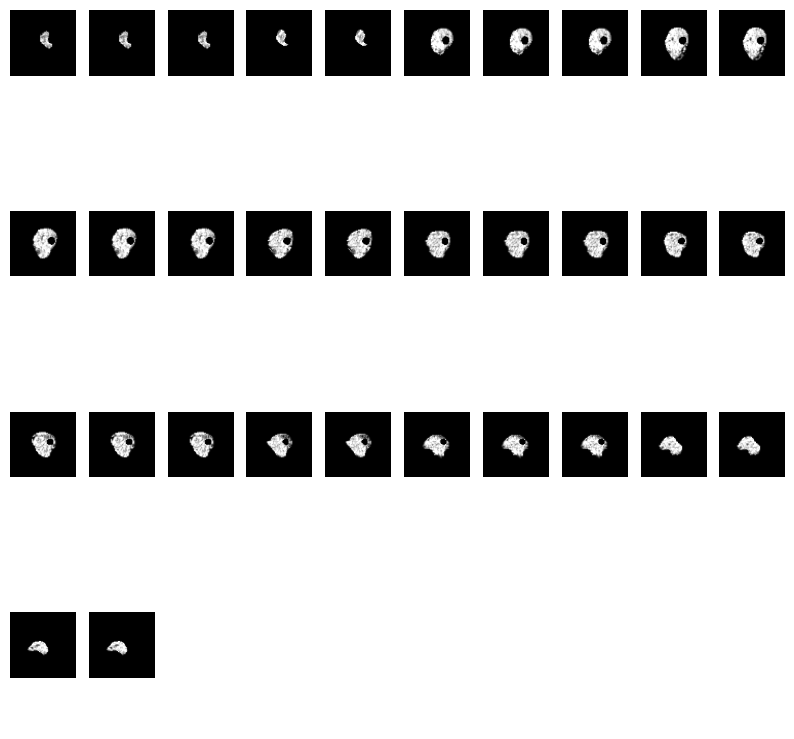

CASE635
Whole and Image are aligned: True
hi
140 232 109 185
CroppedSegment shape: (64, 64, 17)


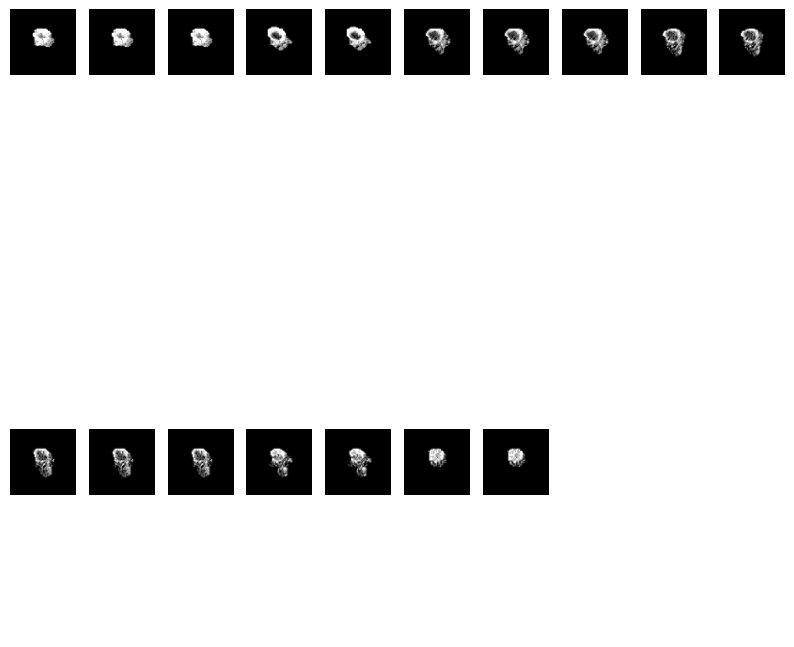

In [13]:
# baseFilepath = 'PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/CASE481_empty'
# segmentFilePath = baseFilepath + '/CASE481_BASE_PRT_TUM_CV.seg.nrrd'
# wholeFilePath = baseFilepath + '/CASE481_BASE_PRT_WHOLE_CT.nrrd' 
# whole, wholeHeader = nrrd.read(wholeFilePath)
# segment, segmentHeader = nrrd.read(segmentFilePath)

allFolders = ['CASE244', 'CASE246', 'CASE247', 'CASE251', 'CASE254', 'CASE256', 'CASE263', 'CASE264', 'CASE265', 'CASE270', 'CASE272', 'CASE274', 
 'CASE467', 'CASE468', 'CASE470', 'CASE471', 'CASE472', 'CASE476', 'CASE479', 'CASE480', 'CASE481_empty', 'CASE482', 'CASE484', 'CASE485', 'CASE488', 'CASE494', 'CASE496', 'CASE499', 
 'CASE500', 'CASE505', 'CASE515', 'CASE520', 'CASE523', 'CASE525', 'CASE531', 'CASE533', 'CASE534', 'CASE535', 'CASE537', 'CASE539', 'CASE541', 'CASE543', 'CASE546', 'CASE547', 'CASE548', 'CASE549', 'CASE550', 'CASE551', 'CASE554', 'CASE555', 'CASE557', 'CASE559', 'CASE560', 'CASE562', 'CASE563', 'CASE564', 'CASE565', 'CASE568', 'CASE569', 'CASE572', 'CASE574', 'CASE575', 'CASE577', 'CASE578', 'CASE580', 'CASE581', 'CASE585', 'CASE586', 'CASE587', 'CASE588', 'CASE589', 'CASE593', 'CASE594', 'CASE596', 'CASE598', 
 'CASE600', 'CASE601', 'CASE602', 'CASE603', 'CASE604', 'CASE605', 'CASE608', 'CASE610', 'CASE611', 'CASE615', 'CASE616', 'CASE621', 'CASE622', 'CASE623', 'CASE624', 'CASE629', 'CASE630', 'CASE632', 'CASE635']

alreadySeem = ['CASE244', 'CASE246', 'CASE247', 'CASE251', 'CASE254', 'CASE256', 'CASE263', 'CASE264', 'CASE265', 'CASE270', 'CASE272', 'CASE274', 
 'CASE467', 'CASE468', 'CASE470', 'CASE471', 'CASE472', 'CASE476', 'CASE479', 'CASE480', 'CASE481_empty', 'CASE482', 'CASE484', 'CASE485', 'CASE488', 'CASE494', 'CASE496', 'CASE499', 
 'CASE500', 'CASE505', 'CASE515', 'CASE520', 'CASE523', 'CASE525', 'CASE531', 'CASE533', 'CASE534', 'CASE535', 'CASE537', 'CASE539', 'CASE541', 'CASE543', 'CASE546', 'CASE547', 'CASE548', 'CASE549', 'CASE550', 'CASE551', 'CASE554', 'CASE555', 'CASE557', 'CASE559', 'CASE560', 'CASE562', 'CASE563', 'CASE564', 'CASE565', 'CASE568', 'CASE569', 'CASE572', 'CASE574', 'CASE575', 'CASE577', 'CASE578', 'CASE580', 'CASE581', 'CASE585', 'CASE586', 'CASE587', 'CASE588', 'CASE589', 'CASE593', 'CASE594', 'CASE596', 'CASE598', 
 'CASE600', 'CASE601', 'CASE602', 'CASE603', 'CASE604', 'CASE605', 'CASE608', 'CASE610', 'CASE611', 'CASE615', 'CASE616', 'CASE621', 'CASE622', 'CASE623', 'CASE624', 'CASE629']
baseFilepath = 'PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/'
for folder in os.listdir(baseFilepath):

    if folder in alreadySeem:
        continue 
    for file in os.listdir(os.path.join(baseFilepath,folder)):
        if file.endswith('CT.nrrd'):
            whole, wholeHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
        elif file.endswith('seg.nrrd'):
            segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
    print('==============================================================')
    print(folder)
    
    croppedSegment = preprocess(whole, wholeHeader, segment, segmentHeader) 

    
    

In [11]:
whole, header = nrrd.read('PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/CASE560/CASE560_BASE_PRT_WHOLE_CT.nrrd')
# whole, header = nrrd.read('PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/CASE533/CASE533_BASE_PRT_TUM_AB.seg.nrrd')
for key, value in header.items():
    print(f"{key}:{value}")

type:short
dimension:3
space:left-posterior-superior
sizes:[512 512  89]
space directions:[[0.898438 0.       0.      ]
 [0.       0.898438 0.      ]
 [0.       0.       2.5     ]]
kinds:['domain', 'domain', 'domain']
endian:little
encoding:raw
space origin:[-235.  -206.7 -395. ]
0008|0005:ISO_IR 100
0008|0008:DERIVED\\SECONDARY\\PROCESSED
0008|0012:20190308
0008|0013:125631
0008|0016:1.2.840.10008.5.1.4.1.1.2
0008|0018:1.2.840.113619.2.80.4202083010.22605.1552067791.130
0008|0020:20190308
0008|0021:20190308
0008|0022:20190308
0008|0023:20190308
0008|0030:123854
0008|0031:123854
0008|0032:125007.891422
0008|0033:125450
0008|0050:519070
0008|0060:CT
0008|0070:GE MEDICAL SYSTEMS
0008|1030:CT ANGIO PANCREAS WITH CH/PEL
0008|103e:PV 5MM
0008|1090:LightSpeed VCT
0008|2111:PROCESSED\\0.898438 \\0.898438
0010|0010:RIA_22-194_000054
0010|0020:RIA_22-194_000_000054
0010|0030:19000101
0010|4000:Project: 22-194; Subject: RIA_22-194_000_000054; Session: 519070
0018|0010:H2O & OMNI 300
0018|0022:HE

In [ ]:
"""
CASE265: weird missing some segmentation inbetween proper images

CASE272: only 6 images

CASE481: somehow is getting the same output as 480

CASE533: missing the HU truth value in the header (volume could've corrupted, check later)

CASE535: weird missing some segmentation inbetween proper images

CASE560: lists everything but the houseinfield unit metadata: 0028|1054

CASE578: weird missing some segmentation inbetween proper images

CASE629: probably got corrupted, same with mha
"""